In [64]:
import os

fault_dir = os.path.join('.', 'datasets','fault')
normal_dir = os.path.join('.', 'datasets','datanormal')

fault_folders = [os.path.join(fault_dir,folder) for folder in os.listdir(fault_dir)]
normal_folders = [os.path.join(normal_dir,folder) for folder in os.listdir(normal_dir)]

In [65]:
import pandas as pd
import numpy as np

fault_files = [os.path.join(files_folder, file)
               for files_folder in fault_folders
               for file in os.listdir(files_folder)]

normal_files = [os.path.join(files_folder, file)
                for files_folder in normal_folders
                for file in os.listdir(files_folder)]


In [66]:
import scipy.signal as sig

b, a = sig.butter(3, 0.02)
cc_df = pd.DataFrame(columns=['series', 'labels', 'sequence'])

for i, file in enumerate(fault_files):
    serie = pd.read_csv(file, header=None)[0]
    filtered_serie = sig.lfilter(b, a, serie)
    cc_df = pd.concat([cc_df, pd.DataFrame(
        {'series': [filtered_serie], 'labels':0, 'sequence':i})])

for i, file in enumerate(normal_files):
    serie = pd.read_csv(file, header=None)[0]
    filtered_serie = sig.lfilter(b, a, serie)
    cc_df = pd.concat([cc_df, pd.DataFrame(
        {'series': [filtered_serie], 'labels':1, 'sequence':i + 87})])

cc_df = cc_df.set_index('sequence')
cc_df['labels'] = cc_df['labels'].astype('int')
cc_df.head()

e:\conda\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,series,labels
sequence,,
0,"[-2.178729607805366e-05, -0.000149397950653310...",0
1,"[-2.013090079756806e-06, -1.448455683622226e-0...",0
2,"[2.3800444450799395e-05, 0.0001638829373628374...",0
3,"[-2.178613021827503e-05, -0.000149382358028544...",0
4,"[-2.0098256723766478e-06, -1.446261162525388e-...",0


### Data images

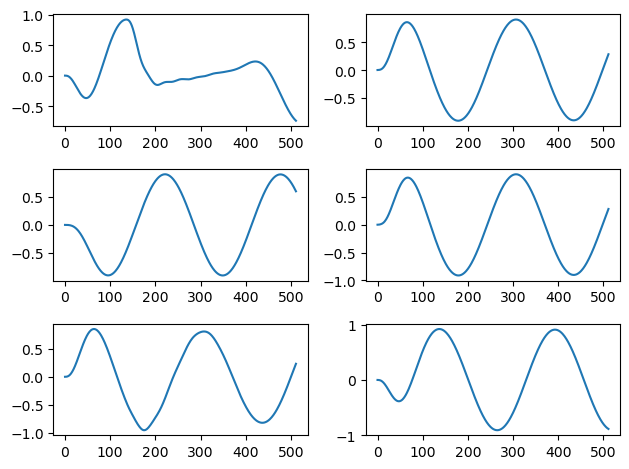

In [67]:
import matplotlib.pyplot as plt

idxes = [(np.random.randint(0, cc_df.shape[0])) for i in range(6)]

fig, axs = plt.subplots(3, 2)

for i in range(2):
    for j in range(3):
        axs[j, i].plot(cc_df.loc[idxes[i + 2*j]]['series'])
        
plt.tight_layout()

### Split Data

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cc_df['series'], cc_df['labels'], shuffle=True, test_size=0.25)

In [69]:
X_train

sequence
105    [-2.2365562528253098e-05, -0.00015337869844499...
143    [2.380132332768793e-05, 0.00016389056923399173...
172    [-2.0089338771296552e-06, -1.4455856648641125e...
61     [-2.013119226251272e-06, -1.4485864766417084e-...
36     [-2.178642168321969e-05, -0.000149393688540824...
                             ...                        
98     [2.3791836203844286e-05, 0.0001638259745881663...
109    [-2.018178005602304e-06, -1.4519168738605253e-...
148    [-2.013428001937828e-06, -1.4486681721889151e-...
0      [-2.178729607805366e-05, -0.000149397950653310...
134    [2.3815906326185635e-05, 0.0001639903154970302...
Name: series, Length: 130, dtype: object

### Use RandomForectClassifier

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(np.vstack(X_train.to_numpy()), y_train.values)

RandomForestClassifier(n_estimators=10)

In [71]:
accuracy_score(y_test, classifier.predict(np.vstack(X_test)))

1.0

### Use RocketClassifier

In [72]:
from sktime.classification.kernel_based import RocketClassifier

rocket = RocketClassifier(num_kernels= 1000)
rocket.fit(np.vstack(X_train), y_train)

RocketClassifier(num_kernels=1000)

In [73]:
accuracy_score(y_test, rocket.predict(np.vstack(X_test)))

1.0

### Use catch22

In [75]:
from sktime.transformations.panel.catch22 import Catch22
from sktime.pipeline import make_pipeline

catch22 = Catch22()
randf = RandomForestClassifier(n_estimators=100)
pipe = make_pipeline(catch22, randf)

In [76]:
pipe.fit(np.vstack(X_train), y_train)

SklearnClassifierPipeline(classifier=RandomForestClassifier(),
                          transformers=[Catch22()])

In [77]:
accuracy_score(y_test, pipe.predict(np.vstack(X_test)))

1.0

### Use catboost

In [82]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(
    iterations=10,
    learning_rate=0.001
)

cb.fit(np.vstack(X_train), y_train)

0:	learn: 0.6913496	total: 22ms	remaining: 198ms
1:	learn: 0.6895806	total: 38.7ms	remaining: 155ms
2:	learn: 0.6881593	total: 55.3ms	remaining: 129ms
3:	learn: 0.6864392	total: 74ms	remaining: 111ms
4:	learn: 0.6847731	total: 90.9ms	remaining: 90.9ms
5:	learn: 0.6830635	total: 109ms	remaining: 72.6ms
6:	learn: 0.6816809	total: 126ms	remaining: 53.9ms
7:	learn: 0.6800698	total: 143ms	remaining: 35.7ms
8:	learn: 0.6785409	total: 160ms	remaining: 17.8ms
9:	learn: 0.6768184	total: 179ms	remaining: 0us


In [83]:
accuracy_score(y_test, cb.predict(np.vstack(X_test)))

1.0